<a href="https://colab.research.google.com/github/ArtemNechaev/stepik_nnets/blob/main/task1_20newsgroups_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Тематическая классификация длинных текстов - TFIDF и LogReg

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import sys; sys.path.append('./stepik-dl-nlp')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
    vectorize_texts, SparseFeaturesDataset
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

init_random_seed()

## Предобработка текстов и подготовка признаков

In [ ]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))
print()
id = 400
print(train_source['data'][id].strip())

print()
print('Метка', train_source['target'][id])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: hooper@ccs.QueensU.CA (Andy Hooper)
Subject: Re: text of White House announcement and Q&As on clipper chip encryption
Organization: Queen's University, Kingston
Distribution: na
Lines: 3

Isn't Clipper a trademark of Fairchild Semiconductor?

Andy Hooper

Метка 11


### Подготовка признаков

In [ ]:
train_tokenized = tokenize_corpus(train_source['data'])
test_tokenized = tokenize_corpus(test_source['data'])

print(' '.join(train_tokenized[0]))

from lerxst where thing subject what this nntp posting host rac3 organization university maryland college park lines wondering anyone there could enlighten this other door sports looked from late early called bricklin doors were really small addition front bumper separate from rest body this know anyone tellme model name engine specs years production where this made history whatever info have this funky looking please mail thanks brought your neighborhood lerxst


In [ ]:
MAX_DF = 0.8
MIN_COUNT = 5
vocabulary, word_doc_freq  = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 21628
[('that', 0), ('this', 1), ('have', 2), ('with', 3), ('writes', 4), ('article', 5), ('posting', 6), ('host', 7), ('nntp', 8), ('there', 9)]


In [ ]:
p_ab = np.zeros((20, UNIQUE_WORDS_N))
count_words_bylabel = np.zeros((20,1))

for i in range(20):
  texts = np.array(train_tokenized)[train_source['target'] == i]
  
  for txt in texts:
      for token in txt:
          if token in vocabulary:
            p_ab[i, vocabulary[token]] +=1


p_a = p_ab.sum(0)/p_ab.sum()
p_ab = p_ab/p_ab.sum(1, keepdims=True)/p_a


In [ ]:
pmi = np.log(p_ab + 1)

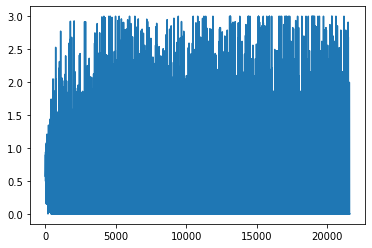

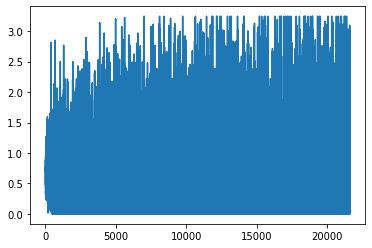

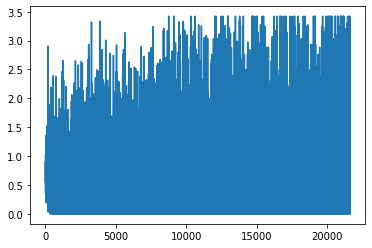

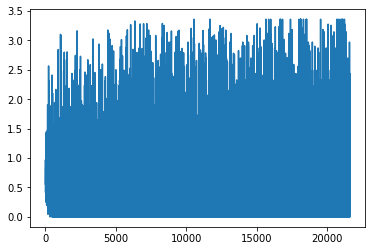

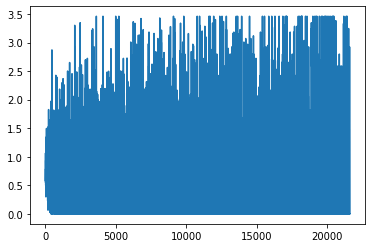

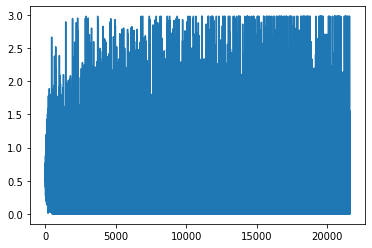

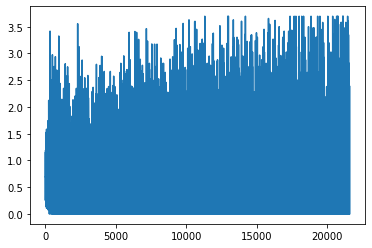

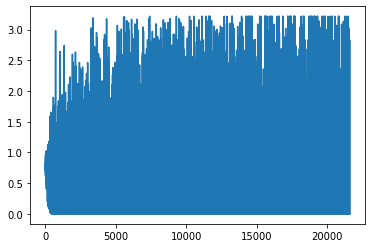

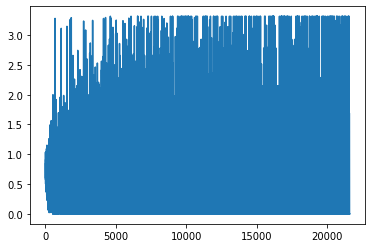

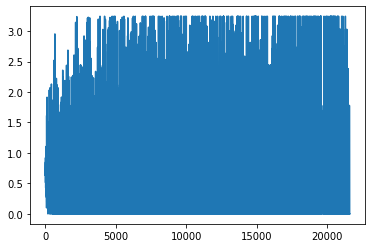

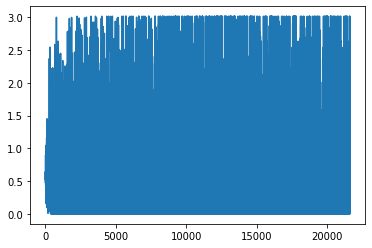

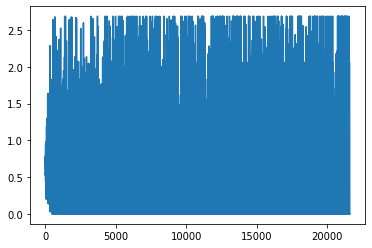

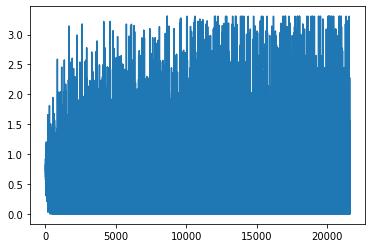

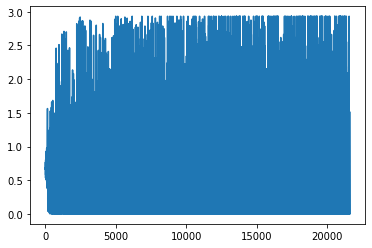

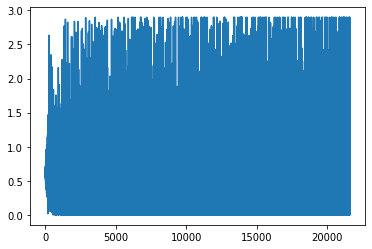

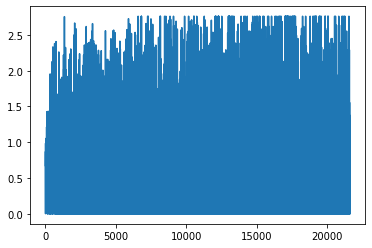

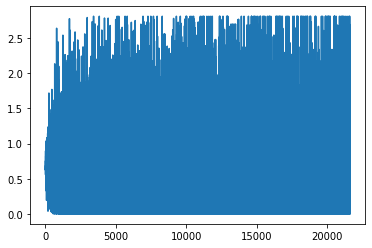

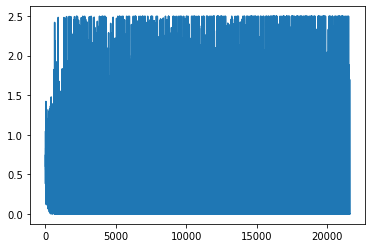

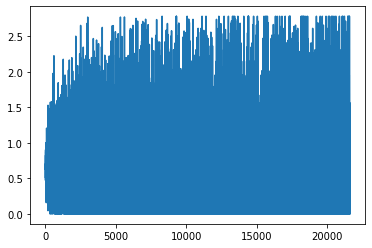

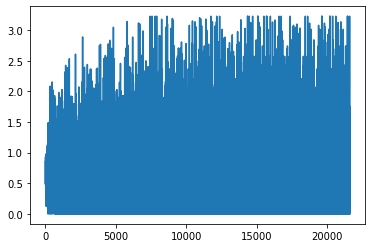

In [ ]:
for i in range(20):

  plt.plot(pmi[i])
  plt.pause(0.001)

In [ ]:
filter = (pmi.max(0)>1.5)

In [ ]:
vocabulary = {word: index for index, (word, last_id) in enumerate(vocabulary.items()) if filter[last_id]}
vocabulary = {word: index for index, (word, last_id) in enumerate(vocabulary.items())}
word_doc_freq = word_doc_freq[filter]
word_doc_freq.shape

In [ ]:
list(vocabulary.items())[:5]

[('distribution', 0), ('please', 1), ('mail', 2), ('last', 3), ('using', 4)]

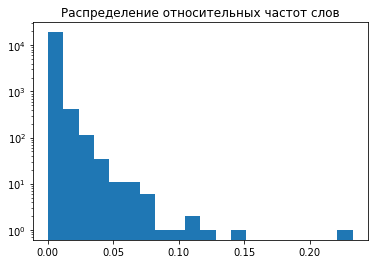

In [ ]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [ ]:
VECTORIZATION_MODE = 'tf'
train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE, scale=False)
test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE, scale=False )

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в тестовой выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

Размерность матрицы признаков обучающей выборки (11314, 19705)
Размерность матрицы признаков тестовой выборки (7532, 19705)

Количество ненулевых элементов в обучающей выборке 524167
Процент заполненности матрицы признаков 0.24%

Количество ненулевых элементов в тестовой выборке 325317
Процент заполненности матрицы признаков 0.22%


In [ ]:
from scipy.sparse.linalg import norm

train_vectors =train_vectors.log1p()
test_vectors = test_vectors.log1p()

train_vectors = train_vectors.multiply(np.log(1/word_doc_freq))+train_vectors
test_vectors = test_vectors.multiply(np.log(1/word_doc_freq))+test_vectors

normL2_train = norm(train_vectors, axis=1)
normL2_test = norm(test_vectors, axis=1)
train_vectors = train_vectors.multiply(1/normL2_train[:,None]).tocsr()
test_vectors = test_vectors.multiply(1/normL2_test[:,None]).tocsr()


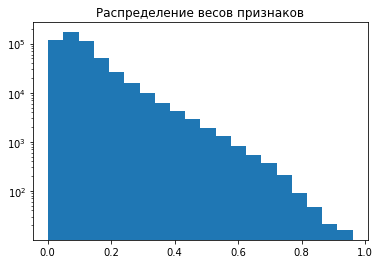

In [ ]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

### Распределение классов

In [ ]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


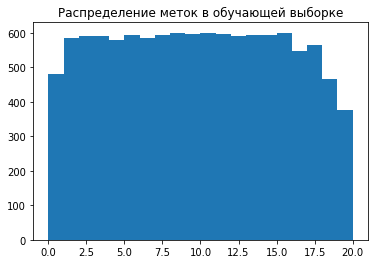

In [ ]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

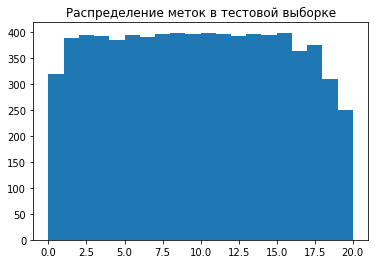

In [ ]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке');

### PyTorch Dataset

In [ ]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

## Обучение модели на PyTorch

In [ ]:
UNIQUE_WORDS_N =  len(vocabulary)

In [ ]:
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)
model = nn.Sequential(
    nn.Linear(UNIQUE_WORDS_N, 500),
    nn.Dropout(0.2),
    nn.Linear(500, 250),
    nn.Linear(250, UNIQUE_LABELS_N)
)
scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, )

best_val_loss, best_model = train_eval_loop(model=model,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-3,
                                            epoch_n=200,
                                            batch_size=64,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=scheduler)

Эпоха 0
Эпоха: 177 итераций, 2.40 сек
Среднее значение функции потерь на обучении 1.1077459010869095
Среднее значение функции потерь на валидации 0.5818554658000752
Новая лучшая модель!

Эпоха 1
Эпоха: 177 итераций, 2.34 сек
Среднее значение функции потерь на обучении 0.1006420633234715
Среднее значение функции потерь на валидации 0.6014907728817503

Эпоха 2
Эпоха: 177 итераций, 2.31 сек
Среднее значение функции потерь на обучении 0.018571642886499984
Среднее значение функции потерь на валидации 0.6235777322771185

Эпоха 3
Эпоха: 177 итераций, 2.32 сек
Среднее значение функции потерь на обучении 0.010803429413150134
Среднее значение функции потерь на валидации 0.6447008470610037

Эпоха 4
Эпоха: 177 итераций, 2.32 сек
Среднее значение функции потерь на обучении 0.007927771810623738
Среднее значение функции потерь на валидации 0.6637487638804872

Эпоха 5
Досрочно остановлено пользователем


## Оценка качества

In [ ]:
model.eval()
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()



test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

100%|██████████| 354/353.5625 [00:01<00:00, 203.62it/s]


Среднее значение функции потерь на обучении 0.11428330838680267
Доля верных ответов 0.9738377231748276



236it [00:01, 203.78it/s]                             

Среднее значение функции потерь на валидации 0.5812959671020508
Доля верных ответов 0.8311205523101434


# Альтернативная реализация на scikit-learn

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_text_simple_regex, sublinear_tf=True,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT)),
                             ('cls', LogisticRegression())))
sklearn_pipeline.fit(train_source['data'], train_source['target']);

## Оценка качества

In [ ]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

Среднее значение функции потерь на обучении 2.491843147374986
Доля верных ответов 0.9751635142301573

Среднее значение функции потерь на валидации 2.65050027936053
Доля верных ответов 0.8301911842804036
